In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b'"Deliverance" is one of the best exploitation films to come out of that wonderful 1970\'s decade from whence so many other exploitation films came.<br /><br />A group of friends sets out on a canoe trip down a river in the south and they become victimized by a bunch of toothless hillbillies who pretty much try to ruin their lives. It\'s awesome.<br /><br />We are treated to anal rape, vicious beatings, bow and arrow killings, shootings, broken bones, etc... A lot like 1974\'s "Texas Chainsaw Massacre," to say that "Deliverance" is believable would be immature. This would never and could never happen, even in the dark ages of 1972.<br /><br />"Deliverance" is a very entertaining ride and packed full of action. It is one in a huge pile of exploitation films to come from the early 70\'s and it (arguably) sits on top of that pile with it\'s great acting, superb cinematography and excellent writing.<br /><br />8 out of 10, kids.'
 b"For those of you that don't that reference, clu

In [8]:
#tao bo ma hoa van ban
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   7,  29, ...,   0,   0,   0],
       [ 16, 144,   5, ...,   0,   0,   0],
       [  1,   2,   1, ...,   0,   0,   0]], dtype=int64)

In [11]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'"Deliverance" is one of the best exploitation films to come out of that wonderful 1970\'s decade from whence so many other exploitation films came.<br /><br />A group of friends sets out on a canoe trip down a river in the south and they become victimized by a bunch of toothless hillbillies who pretty much try to ruin their lives. It\'s awesome.<br /><br />We are treated to anal rape, vicious beatings, bow and arrow killings, shootings, broken bones, etc... A lot like 1974\'s "Texas Chainsaw Massacre," to say that "Deliverance" is believable would be immature. This would never and could never happen, even in the dark ages of 1972.<br /><br />"Deliverance" is a very entertaining ride and packed full of action. It is one in a huge pile of exploitation films to come from the early 70\'s and it (arguably) sits on top of that pile with it\'s great acting, superb cinematography and excellent writing.<br /><br />8 out of 10, kids.'
Round-trip:  [UNK] is one of the best [UNK] film

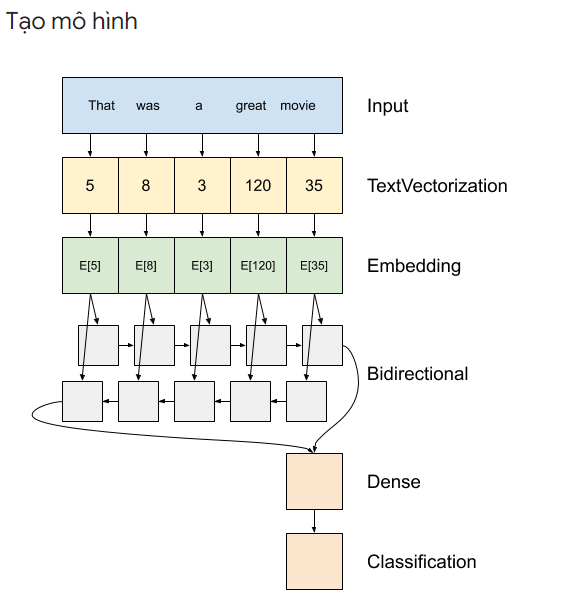

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [14]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-0.00935578]


In [15]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 172ms/step
[-0.00935578]


In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [17]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
391/391 [==============================] - 768s 2s/step - loss: 0.6345 - accuracy: 0.5744 - val_loss: 0.4764 - val_accuracy: 0.7656
Epoch 2/5
391/391 [==============================] - 1085s 3s/step - loss: 0.4205 - accuracy: 0.8033 - val_loss: 0.3949 - val_accuracy: 0.8333
Epoch 3/5
391/391 [==============================] - 890s 2s/step - loss: 0.3568 - accuracy: 0.8415 - val_loss: 0.3561 - val_accuracy: 0.8411
Epoch 4/5
391/391 [==============================] - 873s 2s/step - loss: 0.3310 - accuracy: 0.8570 - val_loss: 0.3363 - val_accuracy: 0.8531
Epoch 5/5
391/391 [==============================] - 1012s 3s/step - loss: 0.3167 - accuracy: 0.8628 - val_loss: 0.3391 - val_accuracy: 0.8438


In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 106s 271ms/step - loss: 0.3301 - accuracy: 0.8433
Test Loss: 0.330130398273468
Test Accuracy: 0.843280017375946


(0.0, 0.6504226610064506)

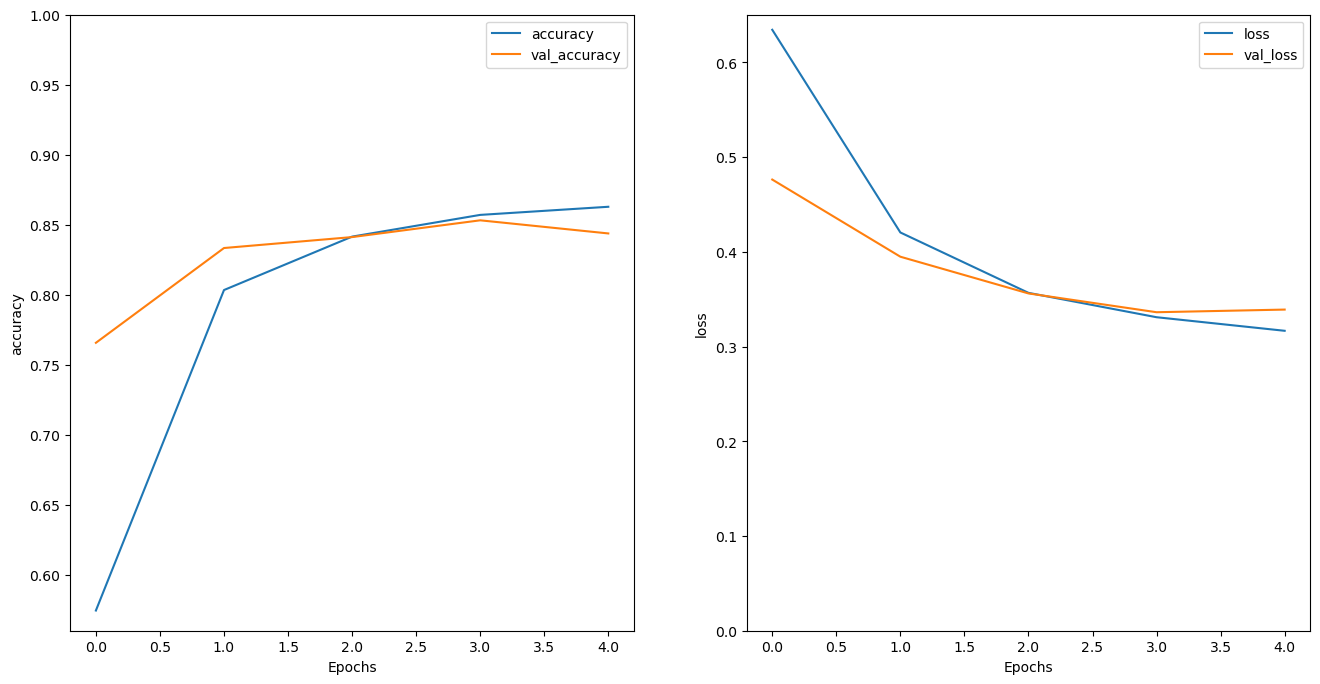

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


# LSTM
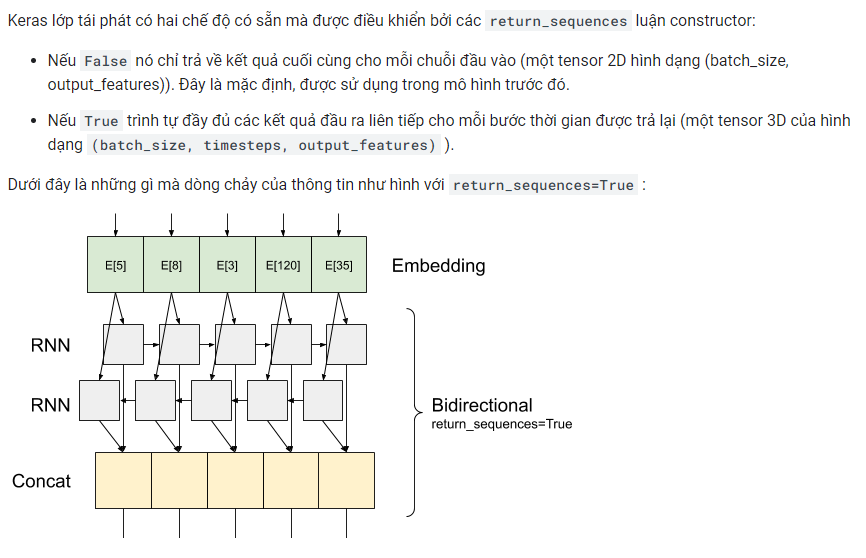

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
391/391 [==============================] - 1789s 5s/step - loss: 0.6038 - accuracy: 0.6048 - val_loss: 0.4092 - val_accuracy: 0.8240
Epoch 2/5
391/391 [==============================] - 1518s 4s/step - loss: 0.3696 - accuracy: 0.8369 - val_loss: 0.3492 - val_accuracy: 0.8510
Epoch 3/5
391/391 [==============================] - 1509s 4s/step - loss: 0.3304 - accuracy: 0.8573 - val_loss: 0.3412 - val_accuracy: 0.8573
Epoch 4/5
391/391 [==============================] - 1588s 4s/step - loss: 0.3156 - accuracy: 0.8651 - val_loss: 0.3277 - val_accuracy: 0.8516
Epoch 5/5
391/391 [==============================] - 1663s 4s/step - loss: 0.3080 - accuracy: 0.8676 - val_loss: 0.3466 - val_accuracy: 0.8271


In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 394s 1s/step - loss: 0.3375 - accuracy: 0.8335
Test Loss: 0.33747586607933044
Test Accuracy: 0.8335199952125549


In [25]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 7s 7s/step
[[-1.441224]]


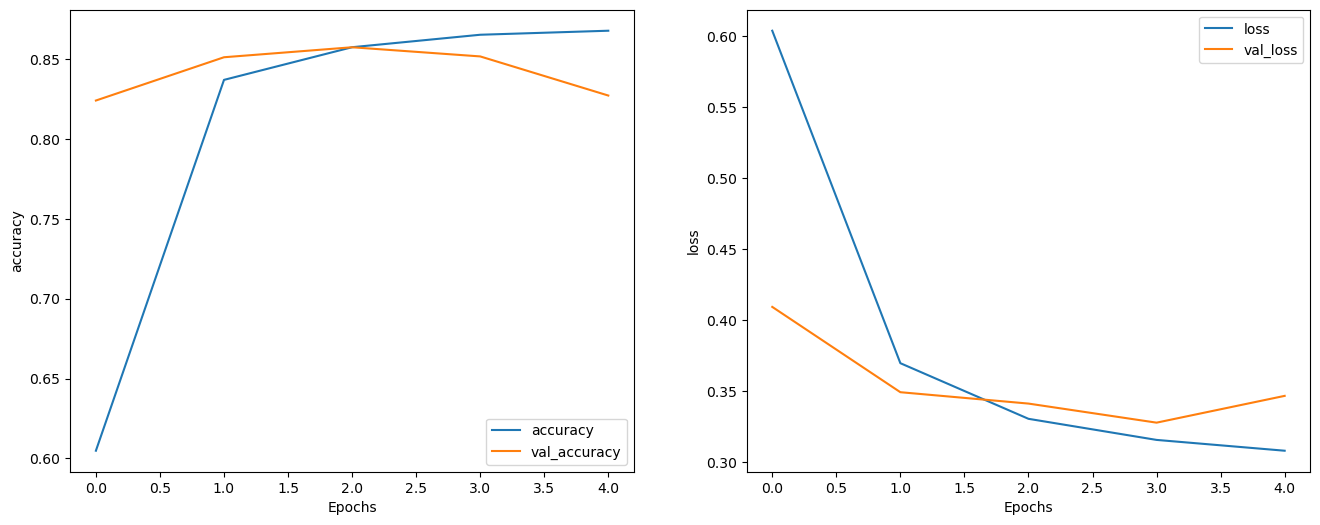

In [26]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')